In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/flight-data/sample_submission.csv
/kaggle/input/flight-data/train.csv
/kaggle/input/flight-data/test.csv


In [2]:
# Load the datasets
train_df = pd.read_csv('/kaggle/input/flight-data/train.csv')
test_df = pd.read_csv('/kaggle/input/flight-data/test.csv')
sample_submission = pd.read_csv('/kaggle/input/flight-data/sample_submission.csv')

# Preview the training dataset
train_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,airline,flight,source,departure,stops,arrival,destination,class,duration,days_left,price
0,0,Vistara,UK-930,Mumbai,Early_Morning,one,Night,Chennai,Business,NaN,40.0,64173
1,1,Air_India,AI-539,Chennai,Evening,one,Morning,Mumbai,Economy,16.08,26.0,4357
2,2,SpiceJet,SG-8107,Delhi,Early_Morning,zero,Morning,Chennai,Economy,2.92,25.0,3251
3,3,NaN,0.00E+00,Hyderabad,Early_Morning,zero,Morning,Bangalore,Economy,1.50,22.0,1776
4,4,Air_India,AI-569,Chennai,Early_Morning,one,Morning,Bangalore,Economy,4.83,20.0,3584


In [3]:
# --- Step 2: Initial Data Inspection ---

print("\n--- 2. Initial Data Inspection ---")

# Display concise summary of the DataFrame, including data types and non-null values
print("\nTrain Data Info:")
train_df.info()

print("\nTest Data Info:")
test_df.info()

# Display the first 5 rows of the DataFrame
print("\nTrain Data Head:")
print(train_df.head())

print("\nTest Data Head:")
print(test_df.head())

# Generate descriptive statistics for all columns (numerical and categorical)
# 'include='all'' ensures statistics for object/categorical columns are also shown
print("\nTrain Data Description:")
print(train_df.describe(include='all'))

print("\nTest Data Description:")
print(test_df.describe(include='all'))


--- 2. Initial Data Inspection ---

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           40000 non-null  int64  
 1   airline      35387 non-null  object 
 2   flight       40000 non-null  object 
 3   source       40000 non-null  object 
 4   departure    35208 non-null  object 
 5   stops        37681 non-null  object 
 6   arrival      40000 non-null  object 
 7   destination  40000 non-null  object 
 8   class        40000 non-null  object 
 9   duration     36987 non-null  float64
 10  days_left    35562 non-null  float64
 11  price        40000 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 3.7+ MB

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

In [4]:
import pandas as pd

print("--- Identifying and Handling Duplicates ---")

duplicate_rows_count = train_df.duplicated(subset=[col for col in train_df.columns if col not in ['id', 'price']]).sum()

print(f"\nNumber of duplicate rows found in training data (based on features): {duplicate_rows_count}")

if duplicate_rows_count > 0:
    print("Dropping duplicate rows from training data...")
    train_df_deduplicated = train_df.drop_duplicates(subset=[col for col in train_df.columns if col not in ['id', 'price']], keep='first')
    print(f"Original training data shape: {train_df.shape}")
    print(f"Training data shape after dropping duplicates: {train_df_deduplicated.shape}")
    train_df = train_df_deduplicated
    print("Duplicates handled (dropped).")
else:
    print("No duplicate rows found in training data.")

--- Identifying and Handling Duplicates ---

Number of duplicate rows found in training data (based on features): 488
Dropping duplicate rows from training data...
Original training data shape: (40000, 12)
Training data shape after dropping duplicates: (39512, 12)
Duplicates handled (dropped).


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define the target and ID columns
TARGET_COLUMN = 'price'
ID_COLUMN = 'id'

# Create copies to avoid modifying original DataFrames
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

# Separate target variable from training data
y_train = train_df_copy[TARGET_COLUMN]
X_train = train_df_copy.drop(columns=[TARGET_COLUMN])

# Store test IDs for the submission file before dropping the ID column from features
test_ids = test_df_copy[ID_COLUMN]
X_test = test_df_copy.drop(columns=[ID_COLUMN])
X_train = X_train.drop(columns=[ID_COLUMN]) # Drop ID from training features as well

print("--- Initial Shapes (after dropping ID and target) ---")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)

--- Initial Shapes (after dropping ID and target) ---
X_train shape: (39512, 10)
y_train shape: (39512,)
X_test shape: (10000, 10)


In [6]:
# --- 2.1 Feature Engineering and Data Type Correction ---
print("\n--- Feature Engineering & Data Type Correction ---")

# The 'stops' column has string values like 'zero', 'one', 'two_or_more'.
# Convert them to numerical representations.
stops_mapping = {'zero': 0, 'one': 1, 'two_or_more': 2}
for df in [X_train, X_test]:
    # Replace the mapping and fill NaN with a placeholder (e.g., -1) that SimpleImputer can then handle
    df['stops'] = df['stops'].map(stops_mapping)
    
    # The `flight` column has a mix of strings and a corrupted numerical value ('0.00E+00').
    # We'll treat it as a string/categorical feature.
    df['flight'] = df['flight'].astype(str)
    
# Let's treat 'departure' and 'arrival' as categorical time slots.
# They are already in a good format for this ('Early_Morning', 'Morning', etc.).
# No explicit feature engineering needed beyond treating them as categoricals for encoding.

print("X_train head after initial feature engineering:")
print(X_train.head())
print("\nX_test head after initial feature engineering:")
print(X_test.head())


--- Feature Engineering & Data Type Correction ---
X_train head after initial feature engineering:
     airline    flight     source      departure  stops  arrival destination  \
0    Vistara    UK-930     Mumbai  Early_Morning    1.0    Night     Chennai   
1  Air_India    AI-539    Chennai        Evening    1.0  Morning      Mumbai   
2   SpiceJet   SG-8107      Delhi  Early_Morning    0.0  Morning     Chennai   
3        NaN  0.00E+00  Hyderabad  Early_Morning    0.0  Morning   Bangalore   
4  Air_India    AI-569    Chennai  Early_Morning    1.0  Morning   Bangalore   

      class  duration  days_left  
0  Business       NaN       40.0  
1   Economy     16.08       26.0  
2   Economy      2.92       25.0  
3   Economy      1.50       22.0  
4   Economy      4.83       20.0  

X_test head after initial feature engineering:
     airline   flight     source      departure  stops    arrival destination  \
0    Vistara   UK-816  Bangalore        Morning    0.0  Afternoon       Delhi   

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

In [7]:
# --- 2.2 Identify Column Types for Preprocessing ---
print("\n--- Identifying Column Types for Preprocessing ---")

# Identify numerical and categorical columns after conversions
# Ensure 'stops' which was mapped to numerical is now included in numerical_cols
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()

print(f"Numerical columns for imputation/scaling: {numerical_cols}")
print(f"Categorical columns for imputation/encoding: {categorical_cols}")


--- Identifying Column Types for Preprocessing ---
Numerical columns for imputation/scaling: ['stops', 'duration', 'days_left']
Categorical columns for imputation/encoding: ['airline', 'flight', 'source', 'departure', 'arrival', 'destination', 'class']



--- Identifying and Handling Outliers ---

Analyzing outliers for column: duration
  226 outliers detected (outside 1.5*IQR range).


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


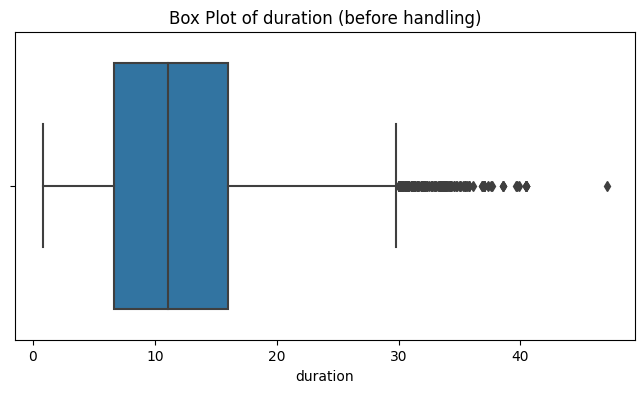

  Capping outliers in column 'duration'...


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


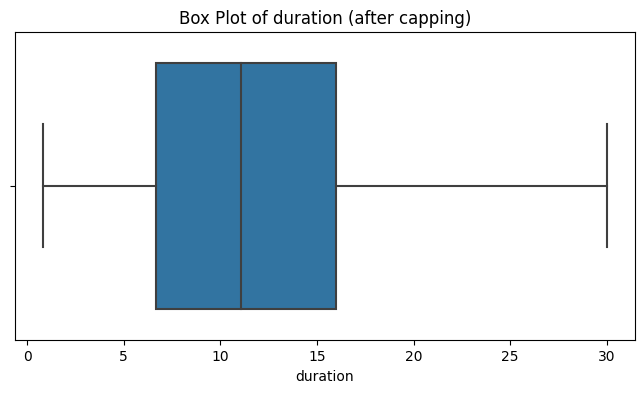

  Outliers in 'duration' have been capped.

Analyzing outliers for column: days_left
  0 outliers detected (outside 1.5*IQR range).


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


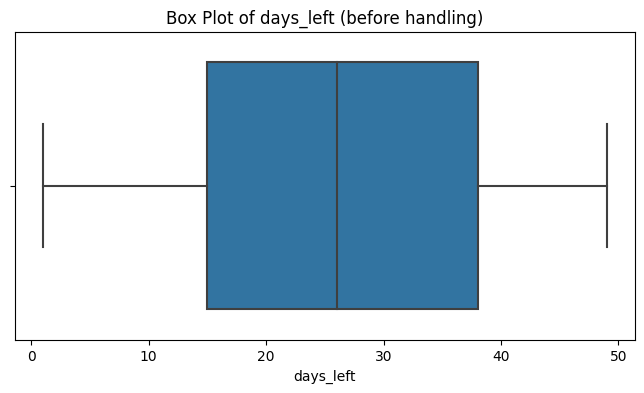

  Capping outliers in column 'days_left'...


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


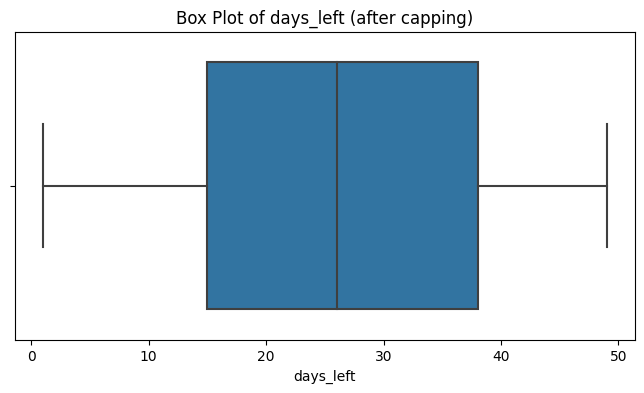

  Outliers in 'days_left' have been capped.

Outlier identification and handling (capping) complete for specified numerical features.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Identifying and Handling Outliers ---")

outlier_cols = ['duration', 'days_left']

for col in outlier_cols:
    if col in X_train.columns:
        print(f"\nAnalyzing outliers for column: {col}")

        Q1 = X_train[col].quantile(0.25)
        Q3 = X_train[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers_count = ((X_train[col] < lower_bound) | (X_train[col] > upper_bound)).sum()
        print(f"  {outliers_count} outliers detected (outside 1.5*IQR range).")
        
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=X_train[col])
        plt.title(f'Box Plot of {col} (before handling)')
        plt.xlabel(col)
        plt.show()

        print(f"  Capping outliers in column '{col}'...")
        X_train[col] = np.where(X_train[col] < lower_bound, lower_bound, X_train[col])
        X_train[col] = np.where(X_train[col] > upper_bound, upper_bound, X_train[col])
        
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=X_train[col])
        plt.title(f'Box Plot of {col} (after capping)')
        plt.xlabel(col)
        plt.show()
        print(f"  Outliers in '{col}' have been capped.")
    else:
        print(f"Column '{col}' not found in X_train for outlier analysis.")

print("\nOutlier identification and handling (capping) complete for specified numerical features.")

In [9]:
# --- 2.3 Handle Missing Values & Encoding with a Pipeline ---
print("\n--- Building and Applying Preprocessing Pipeline ---")

# Create preprocessing pipelines for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute numerical missing values with the mean
    ('scaler', StandardScaler())                 # Scale numerical features (Z-score normalization)
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute categorical missing values with the mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))     # One-Hot encode categorical features
])

# Create a preprocessor using ColumnTransformer
# This applies different transformers to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Fit the preprocessor on the training data and transform both train and test data
print("\nApplying preprocessing pipeline to X_train and X_test...")
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_test_processed = preprocessor.transform(X_test)

# Convert the output (which can be a sparse matrix from OneHotEncoder) to dense arrays
# This is often necessary for many machine learning models
X_train_processed = X_train_processed.toarray()
X_test_processed = X_test_processed.toarray()

print(f"\nShape of processed training data: {X_train_processed.shape}")
print(f"Shape of processed test data: {X_test_processed.shape}")

print("\nPreprocessing and missing value handling complete!")
print("The processed data (X_train_processed, X_test_processed) are now ready for EDA and model training.")


--- Building and Applying Preprocessing Pipeline ---

Applying preprocessing pipeline to X_train and X_test...

Shape of processed training data: (39512, 904)
Shape of processed test data: (10000, 904)

Preprocessing and missing value handling complete!
The processed data (X_train_processed, X_test_processed) are now ready for EDA and model training.



--- Exploratory Data Analysis (EDA) on Raw Data---

--- Target Variable Analysis (Price) ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


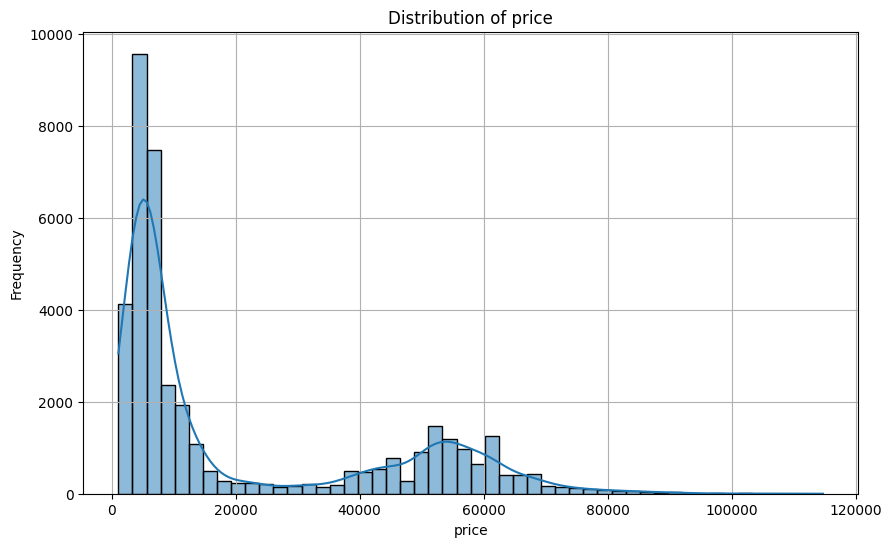


price Statistics:
count     40000.00000
mean      20801.49025
std       22729.14842
min        1105.00000
25%        4687.00000
50%        7353.00000
75%       42521.00000
max      114704.00000
Name: price, dtype: float64
price Skewness: 1.06
price Kurtosis: -0.40


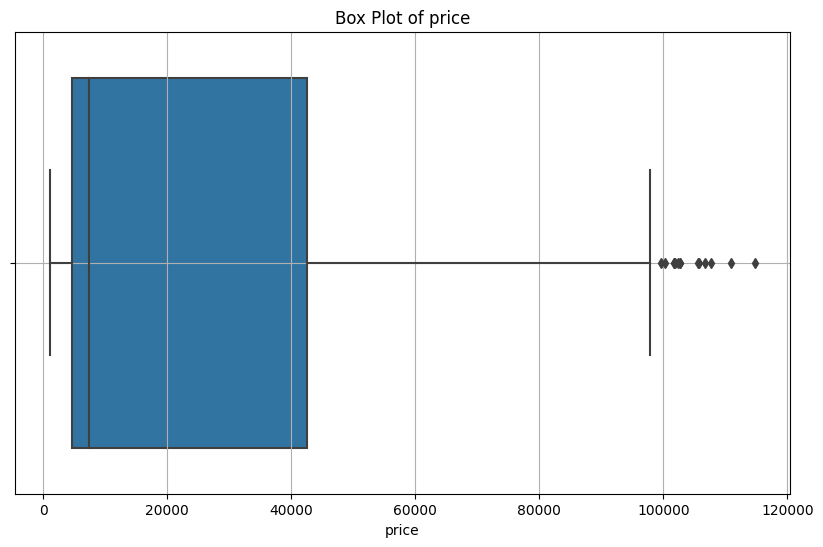


--- Numerical Features Analysis ---


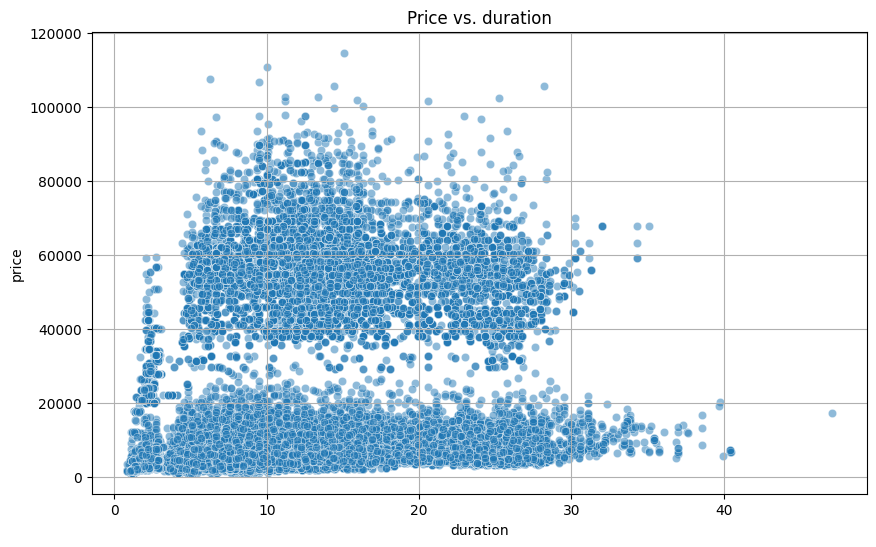

Correlation between duration and price: 0.22


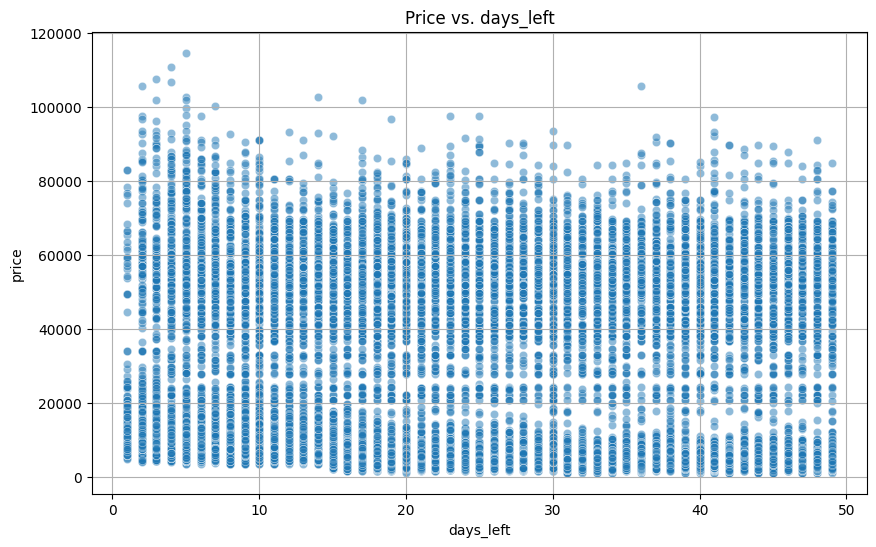

Correlation between days_left and price: -0.09


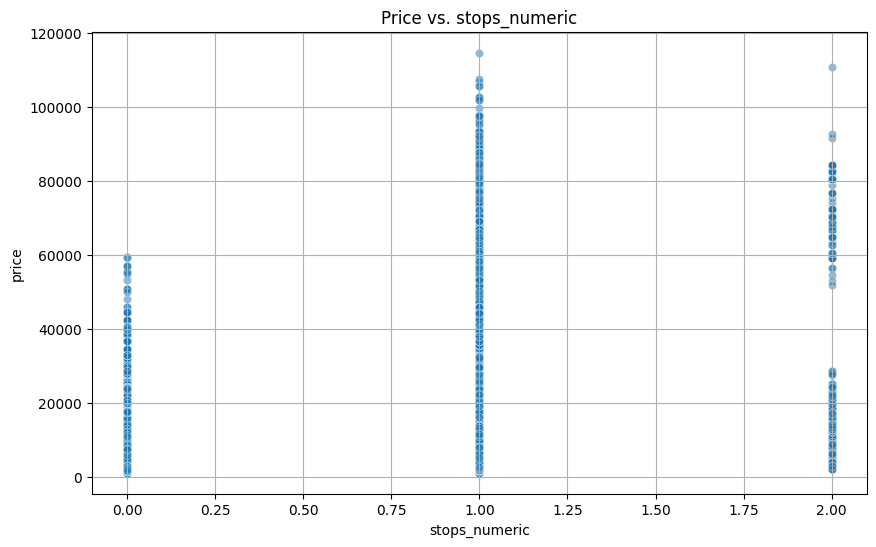

Correlation between stops_numeric and price: 0.13

--- Categorical Features Analysis ---


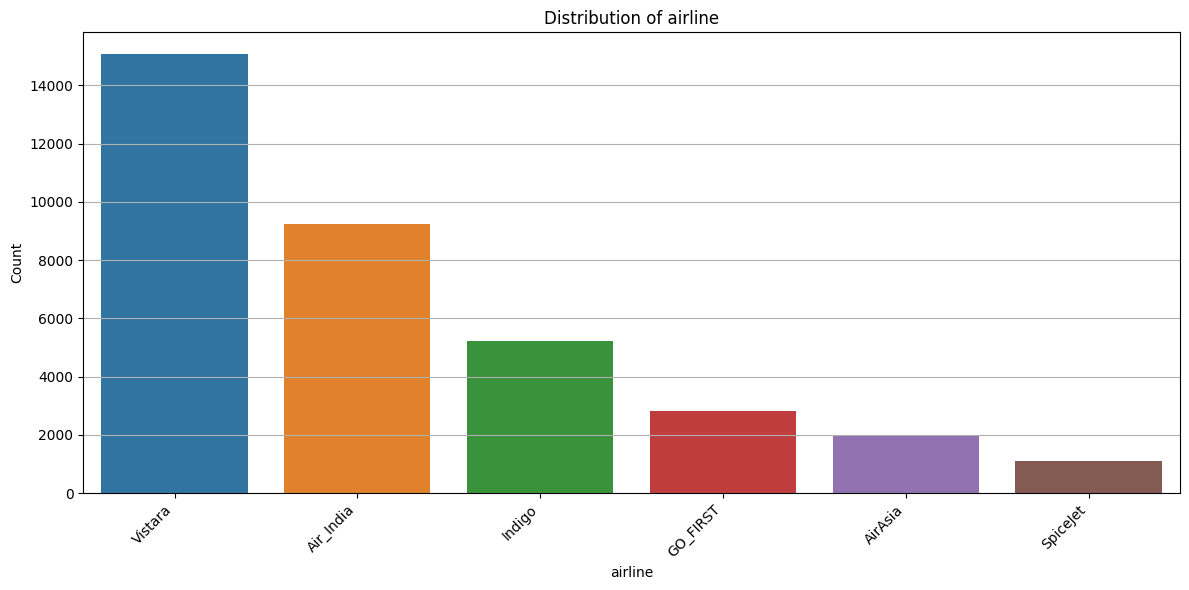

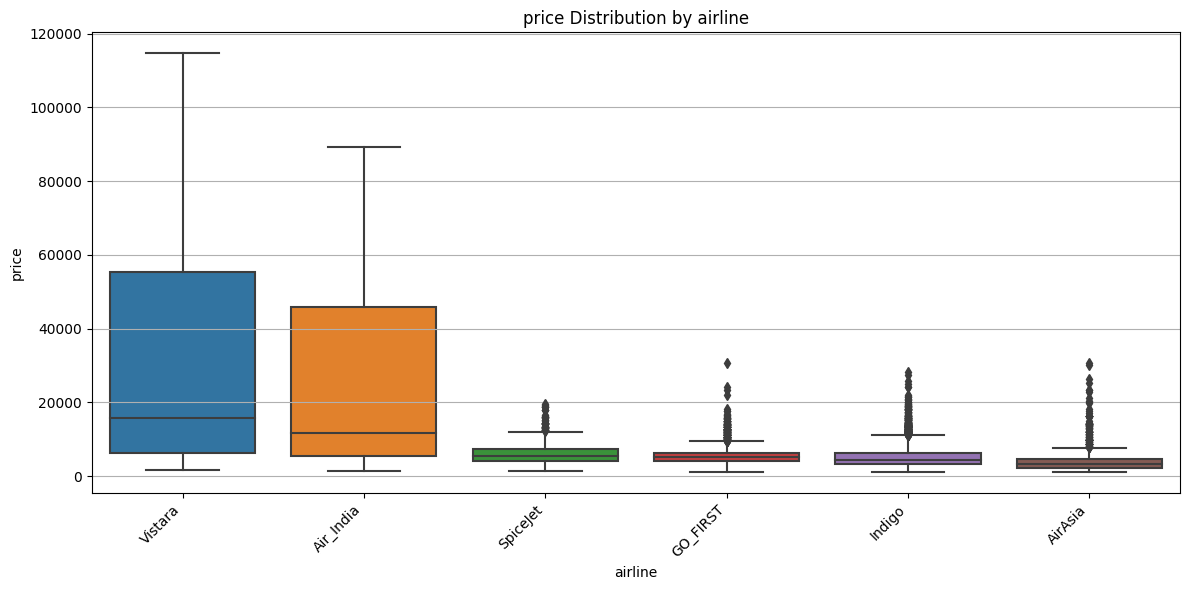

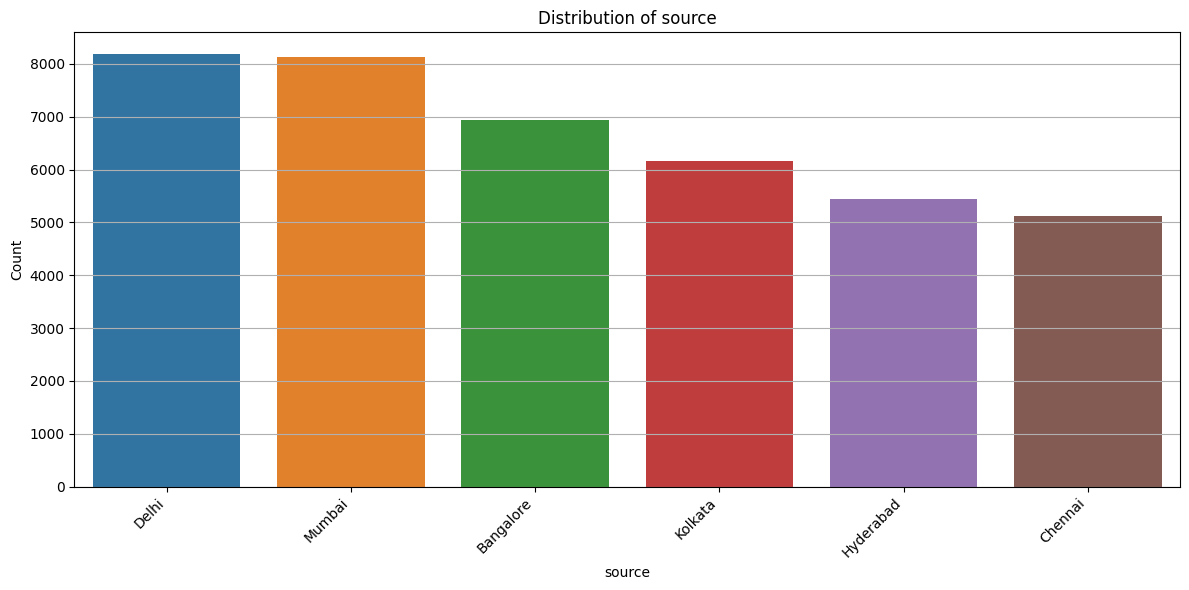

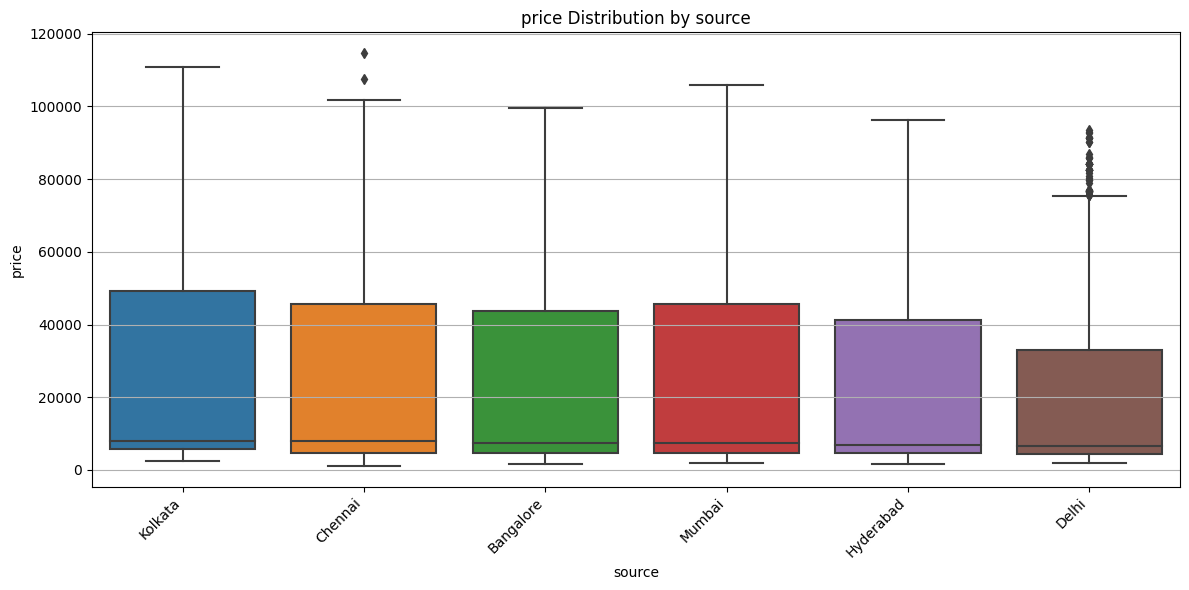

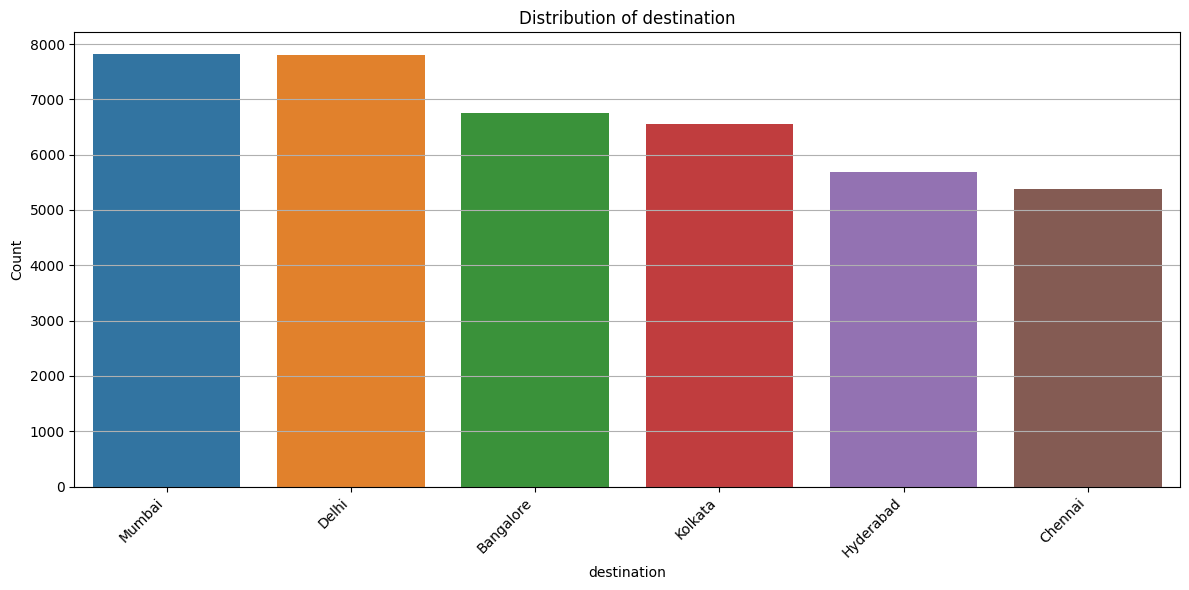

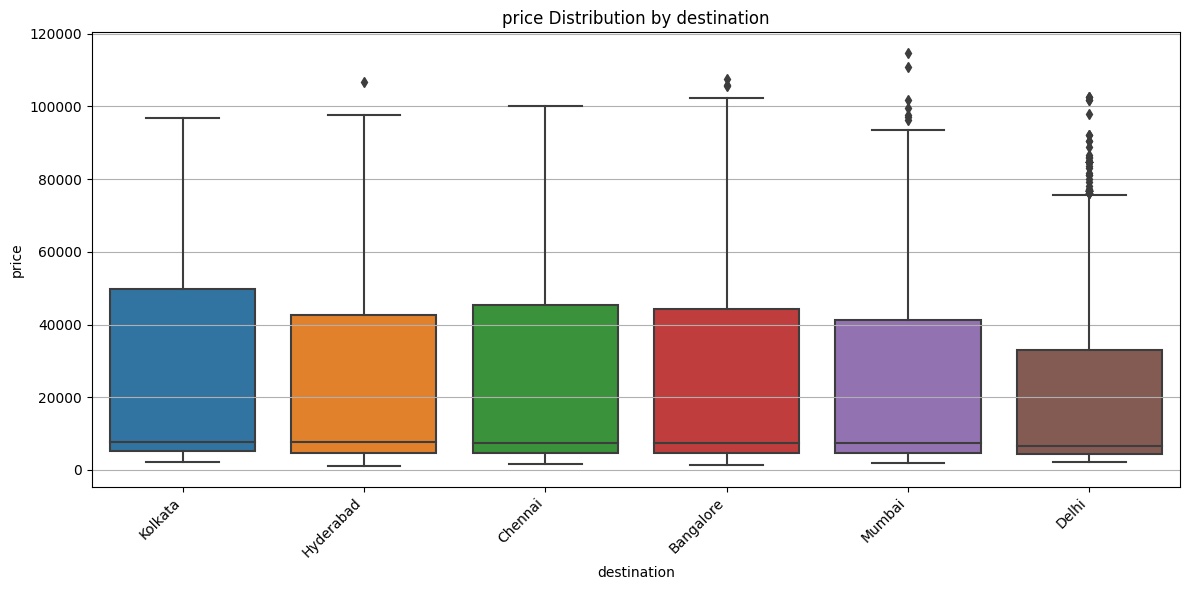

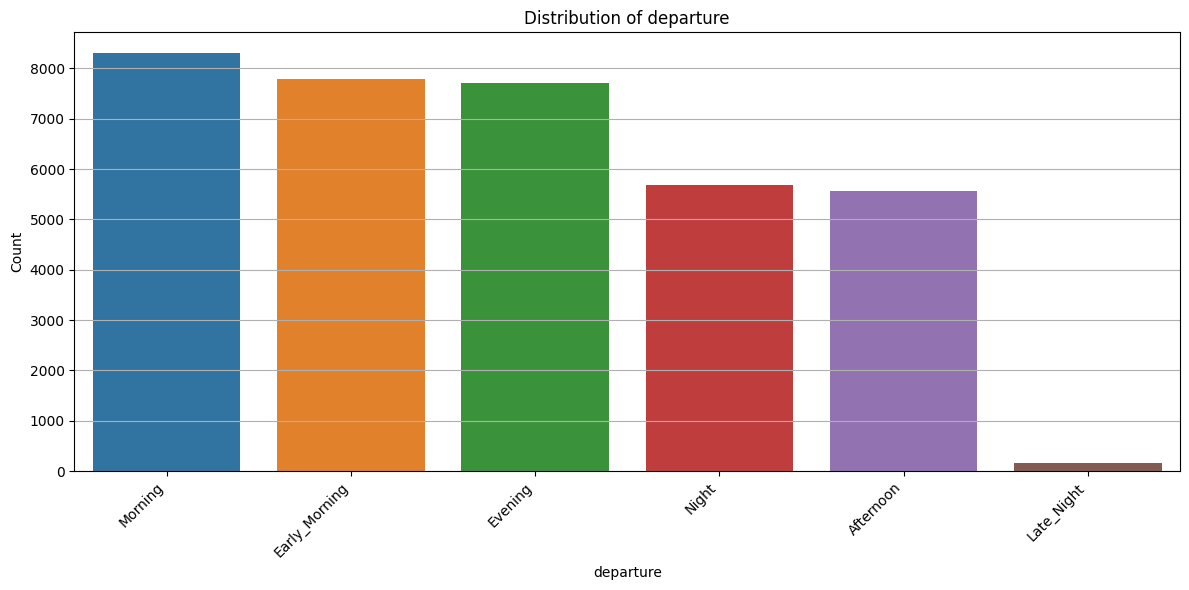

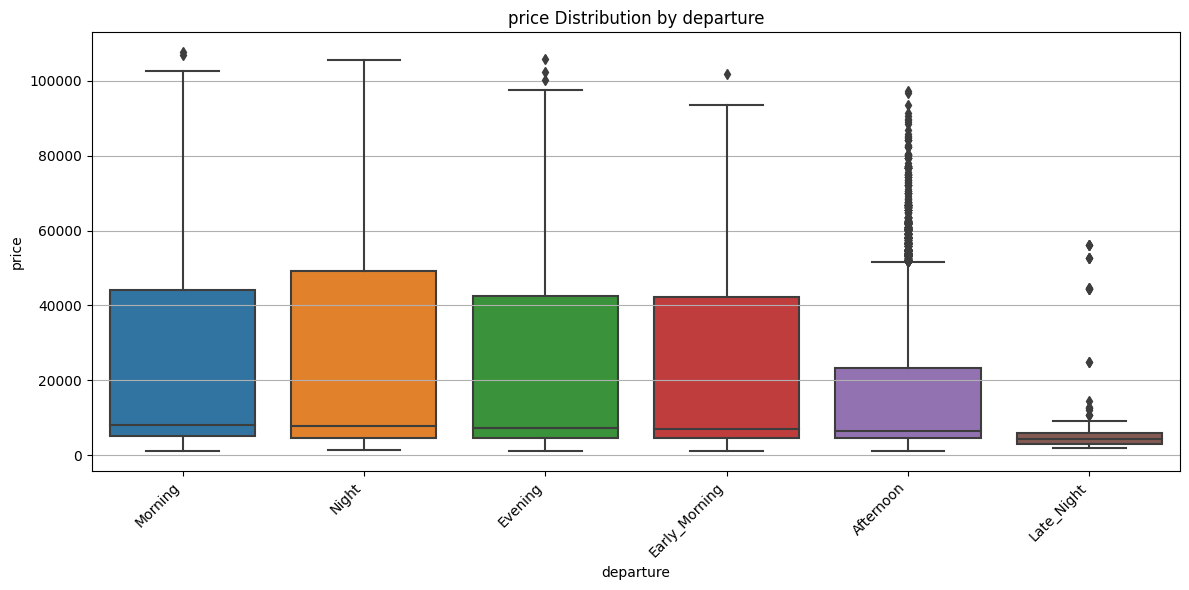

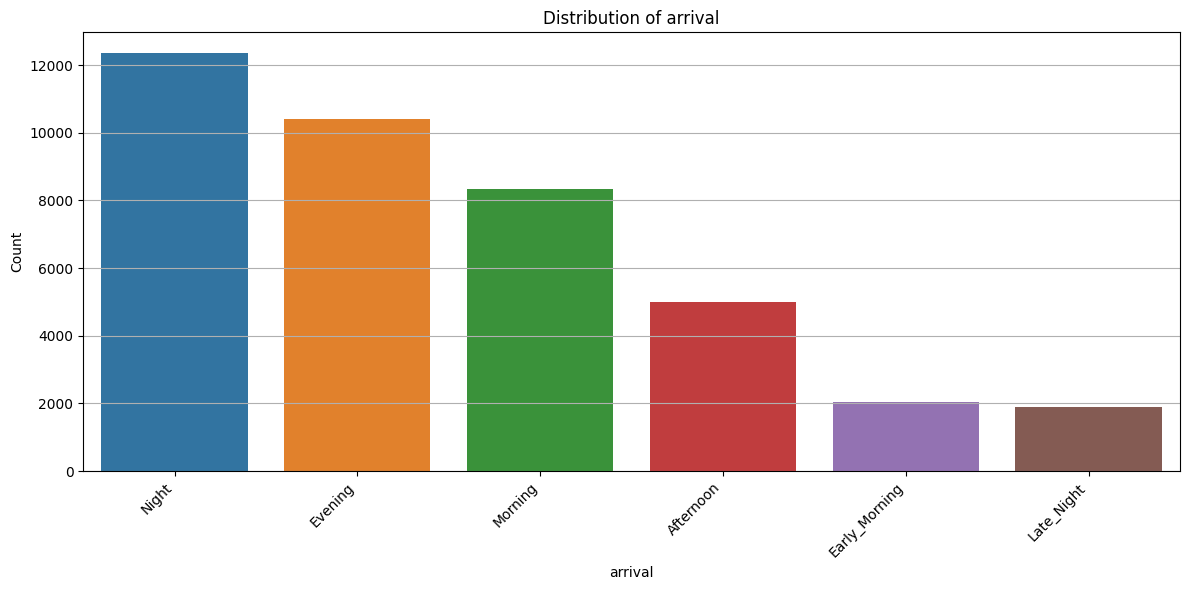

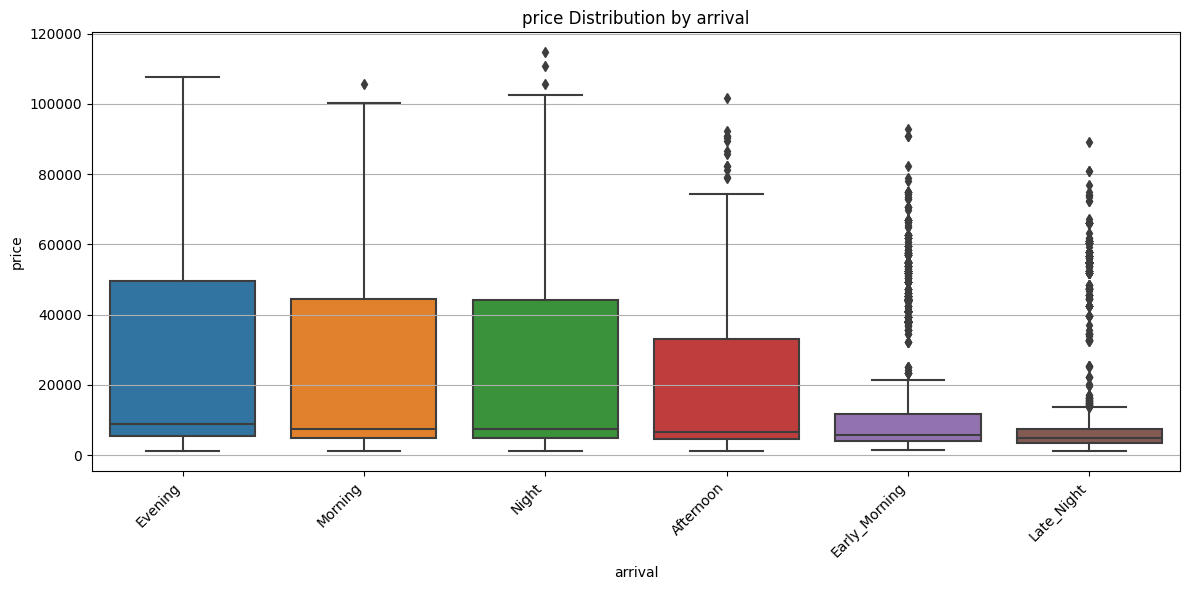

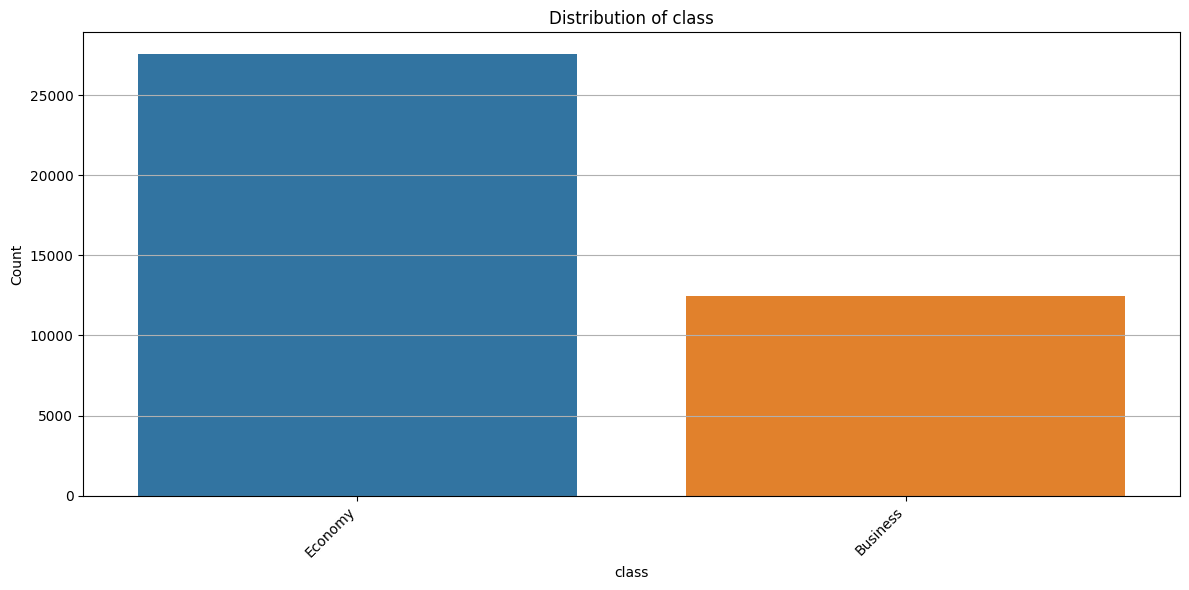

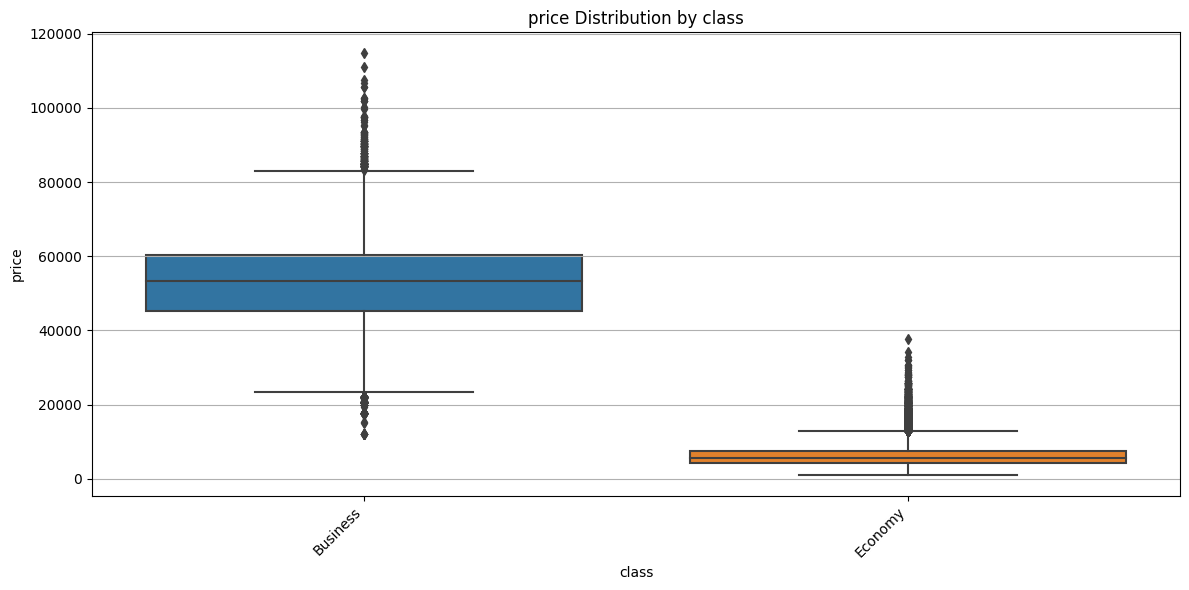


EDA complete. Insights gained can inform further feature engineering or model choices.


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Ensure numpy is imported for functions like np.sqrt

print("\n--- Exploratory Data Analysis (EDA) on Raw Data---")

# Reload original train_df if you want to perform EDA on un-preprocessed data
# This is often useful to understand the original feature distributions and relationships.
train_df_raw_for_eda = pd.read_csv('/kaggle/input/flight-data/train.csv')
test_df_raw_for_eda = pd.read_csv('/kaggle/input/flight-data/test.csv') # Just for reference

# --- 3.1 Target Variable Analysis (Price) ---
print("\n--- Target Variable Analysis (Price) ---")

# Distribution of the target variable (price)
plt.figure(figsize=(10, 6))
sns.histplot(train_df_raw_for_eda[TARGET_COLUMN], kde=True, bins=50)
plt.title(f'Distribution of {TARGET_COLUMN}')
plt.xlabel(TARGET_COLUMN)
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(f"\n{TARGET_COLUMN} Statistics:")
print(train_df_raw_for_eda[TARGET_COLUMN].describe())
print(f"{TARGET_COLUMN} Skewness: {train_df_raw_for_eda[TARGET_COLUMN].skew():.2f}")
print(f"{TARGET_COLUMN} Kurtosis: {train_df_raw_for_eda[TARGET_COLUMN].kurt():.2f}")


# Box plot to identify outliers in price
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df_raw_for_eda[TARGET_COLUMN])
plt.title(f'Box Plot of {TARGET_COLUMN}')
plt.xlabel(TARGET_COLUMN)
plt.grid(True)
plt.show()


# --- 3.2 Numerical Features Analysis ---
print("\n--- Numerical Features Analysis ---")

# The 'stops' column after mapping (for EDA purposes)
train_df_raw_for_eda['stops_numeric'] = train_df_raw_for_eda['stops'].map({'zero': 0, 'one': 1, 'two_or_more': 2})

# Scatter plots for numerical features vs. target
numerical_features_for_eda = ['duration', 'days_left', 'stops_numeric']

for col in numerical_features_for_eda:
    if col in train_df_raw_for_eda.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=train_df_raw_for_eda[col], y=train_df_raw_for_eda[TARGET_COLUMN], alpha=0.5)
        plt.title(f'Price vs. {col}')
        plt.xlabel(col)
        plt.ylabel(TARGET_COLUMN)
        plt.grid(True)
        plt.show()

        # Correlation with target
        print(f"Correlation between {col} and {TARGET_COLUMN}: {train_df_raw_for_eda[col].corr(train_df_raw_for_eda[TARGET_COLUMN]):.2f}")
    else:
        print(f"Warning: {col} not found in raw data for EDA.")


# --- 3.3 Categorical Features Analysis ---
print("\n--- Categorical Features Analysis ---")

categorical_features_for_eda = ['airline', 'source', 'destination', 'departure', 'arrival', 'class']

for col in categorical_features_for_eda:
    if col in train_df_raw_for_eda.columns:
        # Count plots for categorical features
        plt.figure(figsize=(12, 6))
        sns.countplot(x=train_df_raw_for_eda[col], order=train_df_raw_for_eda[col].value_counts().index)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

        # Box plot for categorical features vs. target (price)
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=col, y=TARGET_COLUMN, data=train_df_raw_for_eda, order=train_df_raw_for_eda.groupby(col)[TARGET_COLUMN].median().sort_values(ascending=False).index)
        plt.title(f'{TARGET_COLUMN} Distribution by {col}')
        plt.xlabel(col)
        plt.ylabel(TARGET_COLUMN)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
    else:
        print(f"Warning: {col} not found in raw data for EDA.")

# Clean up temporary column
train_df_raw_for_eda.drop(columns=['stops_numeric'], inplace=True, errors='ignore')

print("\nEDA complete. Insights gained can inform further feature engineering or model choices.")

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import randint, uniform

print("\n--- Training Multiple Machine Learning Models ---")

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_processed, y_train, test_size=0.2, random_state=42
)

print(f"Shapes for model training:")
print(f"  X_train_split: {X_train_split.shape}")
print(f"  y_train_split: {y_train_split.shape}")
print(f"  X_val_split:   {X_val_split.shape}")
print(f"  y_val_split:   {y_val_split.shape}")

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Decision Tree Regressor': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, random_state=42),
    'XGBoost Regressor': XGBRegressor(n_estimators=50, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM Regressor': LGBMRegressor(n_estimators=50, learning_rate=0.1, random_state=42, n_jobs=-1),
    'K-Neighbors Regressor': KNeighborsRegressor(n_neighbors=5)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    try:
        model.fit(X_train_split, y_train_split)
        y_pred = model.predict(X_val_split)
        
        rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))
        r2 = r2_score(y_val_split, y_pred)
        
        results[name] = {'RMSE': rmse, 'R2': r2}
        print(f"{name} - RMSE: {rmse:.4f}, R2: {r2:.4f}")
    except Exception as e:
        print(f"Error training {name}: {e}")
        results[name] = {'RMSE': np.nan, 'R2': np.nan}

results_df = pd.DataFrame(results).T
print("\n--- Model Validation Results (Comparison) ---")
print(results_df.sort_values(by='RMSE'))


--- Training Multiple Machine Learning Models ---
Shapes for model training:
  X_train_split: (31609, 904)
  y_train_split: (31609,)
  X_val_split:   (7903, 904)
  y_val_split:   (7903,)

Training Linear Regression...
Linear Regression - RMSE: 11118913529186.4824, R2: -238677857359379712.0000

Training Ridge Regression...
Ridge Regression - RMSE: 6342.4114, R2: 0.9223

Training Lasso Regression...
Lasso Regression - RMSE: 6367.9650, R2: 0.9217

Training Decision Tree Regressor...
Decision Tree Regressor - RMSE: 4605.9162, R2: 0.9590

Training Random Forest Regressor...
Random Forest Regressor - RMSE: 3513.6470, R2: 0.9762

Training Gradient Boosting Regressor...
Gradient Boosting Regressor - RMSE: 5458.0832, R2: 0.9425

Training XGBoost Regressor...
XGBoost Regressor - RMSE: 4739.7948, R2: 0.9566

Training LightGBM Regressor...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003478 seconds.
You can set `force_row_wise=true` to remove the overhea

In [12]:
print("\n--- Hyperparameter Tuning on 3 Models (RandomizedSearchCV) ---")

print("\n--- Tuning Random Forest Regressor ---")
param_dist_rf = {
    'n_estimators': randint(low=50, high=150),
    'max_depth': randint(low=10, high=25),
    'min_samples_split': randint(low=2, high=8),
    'min_samples_leaf': randint(low=1, high=4)
}
rf_model_tune = RandomForestRegressor(random_state=42, n_jobs=-1)
random_search_rf = RandomizedSearchCV(
    rf_model_tune, param_distributions=param_dist_rf, n_iter=5, cv=3,
    scoring='neg_mean_squared_error', verbose=1, random_state=42, n_jobs=-1
)
random_search_rf.fit(X_train_split, y_train_split)
print(f"Random Forest Best Parameters: {random_search_rf.best_params_}")
print(f"Random Forest Best CV RMSE: {np.sqrt(-random_search_rf.best_score_):.4f}")

print("\n--- Tuning LightGBM Regressor ---")
param_dist_lgbm = {
    'n_estimators': randint(low=50, high=150),
    'learning_rate': uniform(0.01, 0.15),
    'num_leaves': randint(low=20, high=50),
    'max_depth': randint(low=5, high=12)
}
lgbm_model_tune = LGBMRegressor(random_state=42, n_jobs=-1)
random_search_lgbm = RandomizedSearchCV(
    lgbm_model_tune, param_distributions=param_dist_lgbm, n_iter=5, cv=3,
    scoring='neg_mean_squared_error', verbose=1, random_state=42, n_jobs=-1
)
random_search_lgbm.fit(X_train_split, y_train_split)
print(f"LightGBM Best Parameters: {random_search_lgbm.best_params_}")
print(f"LightGBM Best CV RMSE: {np.sqrt(-random_search_lgbm.best_score_):.4f}")

print("\n--- Tuning XGBoost Regressor ---")
param_dist_xgb = {
    'n_estimators': randint(low=50, high=150),
    'learning_rate': uniform(0.01, 0.15),
    'max_depth': randint(low=3, high=8),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}
xgb_model_tune = XGBRegressor(random_state=42, n_jobs=-1)
random_search_xgb = RandomizedSearchCV(
    xgb_model_tune, param_distributions=param_dist_xgb, n_iter=5, cv=3,
    scoring='neg_mean_squared_error', verbose=1, random_state=42, n_jobs=-1
)
random_search_xgb.fit(X_train_split, y_train_split)
print(f"XGBoost Best Parameters: {random_search_xgb.best_params_}")
print(f"XGBoost Best CV RMSE: {np.sqrt(-random_search_xgb.best_score_):.4f}")

final_model = random_search_rf.best_estimator_
print("\nSelected final_model based on Random Forest tuning results.")

print("\n--- Training Final Model on Full Data and Generating Predictions for Submission ---")

TARGET_COLUMN = 'price'
ID_COLUMN = 'id'

print("\nTraining final_model on full processed training data...")
final_model.fit(X_train_processed, y_train)
print("Final model training complete!")

test_predictions = final_model.predict(X_test_processed)

test_predictions[test_predictions < 0] = 0

submission_df = pd.DataFrame({
    ID_COLUMN: test_ids,
    TARGET_COLUMN: test_predictions
})

submission_df.rename(columns={TARGET_COLUMN: sample_submission.columns[1]}, inplace=True)

submission_file_path = 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)

print(f"\nSubmission file created: {submission_file_path}")
print("\nFirst 5 rows of the submission file:")
print(submission_df.head())


--- Hyperparameter Tuning on 3 Models (RandomizedSearchCV) ---

--- Tuning Random Forest Regressor ---
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Random Forest Best Parameters: {'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 132}
Random Forest Best CV RMSE: 3731.4773

--- Tuning LightGBM Regressor ---
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 848
[LightGBM] [Info] Number of data points in the train set: 21072, number of used features: 272
[LightGBM] [Info] Start training from score 20588.215784
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 844
[LightGBM] [Info] Number of data points in th

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 844
[LightGBM] [Info] Number of data points in the train set: 21073, number of used features: 270
[LightGBM] [Info] Start training from score 20823.716130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 848
[LightGBM] [Info] Number of data points in the train set: 21072, number of used features: 272
[LightGBM] [Info] Start training from score 20588.215784
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067297 seconds.
You can set `force_col_wise=true` to remove the overh